In [1]:
import pandas as pd
import pdb
from pathlib import Path
from fastai.vision import *
from fastai.vision.gan import *

In [2]:
simDataX = np.linspace(0,2*np.pi,100)
amp,phase = np.random.rand(10000,1), np.random.rand(10000,1) * np.pi
simDataY = amp * np.sin(phase * simDataX.reshape(1,-1))

In [3]:
yT = torch.tensor(simDataY,dtype=torch.float).unsqueeze(-1)
phaseT = torch.tensor(phase,dtype=torch.float).squeeze(1)

trainDS = torch.utils.data.TensorDataset(yT[:8000],yT[:8000].squeeze(-1))
valDS = torch.utils.data.TensorDataset(yT[8000:],yT[8000:].squeeze(-1))
trainDS.items = [1,2,3]
valDS.items = [1,2,3]
data = DataBunch.create(trainDS,valDS,num_workers=0)

In [68]:
class SineEnc(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.LSTM(1,350,2,batch_first=True,bias=False)
        self.attn = torch.nn.Linear(350,1,bias=False)
        self.mean = torch.nn.Linear(350,20)
        self.var = torch.nn.Linear(350,20)
        
    def forward(self,ts):
        output,(h_n,c_n) = self.rnn(ts.float())
        #a = torch.softmax(self.attn(output),dim=1)
        #self.attns = a
        #output = a * output
        #output = output.sum(dim=1)
        output = output[:,-1]
        return self.mean(output), self.var(output)

In [80]:
class SineEnc(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.LSTM(1,350,batch_first=True)
        self.hiddenAttn = torch.nn.Linear(350,100,bias=False)
        self.lastAttn = torch.nn.Linear(350,100)
        self.attn = torch.nn.Linear(100,1,bias=False)
        self.mean = torch.nn.Linear(350,20)
        self.var = torch.nn.Linear(350,20)
        
    def forward(self,ts):
        output, (h,c) = self.rnn(ts)
        lastWeight = self.lastAttn(output[:,-1])
        hiddenWeight = self.hiddenAttn(output)
        u = torch.tanh(hiddenWeight + lastWeight.unsqueeze(1))
        a = torch.softmax(self.attn(u),0)
        output = (a*output).sum(dim=1)
        return self.mean(output), self.var(output)

In [81]:
class SineDec(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = torch.nn.LSTM(20,200,1,batch_first=True,bias=False)
        self.out = torch.nn.Linear(200,1)
    
    def forward(self, mean, var):
#         sample = mean
#         if self.training:
        std = torch.exp(0.5 * var)
        eps = torch.randn_like(std)
        sample = eps.mul(std).add_(mean)
        
        sample = sample.unsqueeze(1).expand(-1,100,-1)
        output, (h_n,c_n) = self.rnn(sample)
        return self.out(output).squeeze(-1)
        #return output.squeeze(-1)

In [82]:
class VAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = SineEnc()
        self.dec = SineDec()
        
    def forward(self,ts):
        mean, var = self.enc(ts)
        out = self.dec(mean,var)
        return out,mean,var

In [83]:
def VAELoss(p,target):
    pred,mean,var = p
    mse = torch.nn.functional.mse_loss(pred,target,reduction="sum")
    kld = -0.5 * torch.sum(1+var-mean.pow(2)-var.exp())
    return mse + kld

In [91]:
model = VAE()
learn = Learner(data,model,loss_func=VAELoss)

In [92]:
x,y = next(iter(data.train_dl))
learn.model(x)[0].size()

torch.Size([64, 100])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


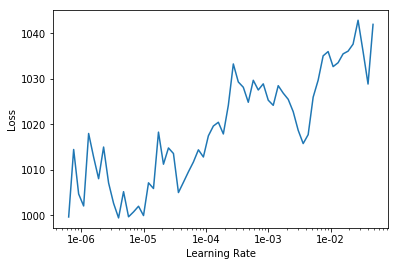

In [90]:
learn.lr_find()
learn.recorder.plot()

In [95]:
learn.fit(10,1e-3)

epoch,train_loss,valid_loss
1,837.874084,830.750488
2,888.793823,876.177734
3,863.626770,831.128235
4,846.477356,825.648682
5,880.941406,845.418335
6,849.986816,825.245972
7,846.620667,828.081238
8,830.751709,821.773438
9,842.703125,824.068542
10,844.675781,847.336975


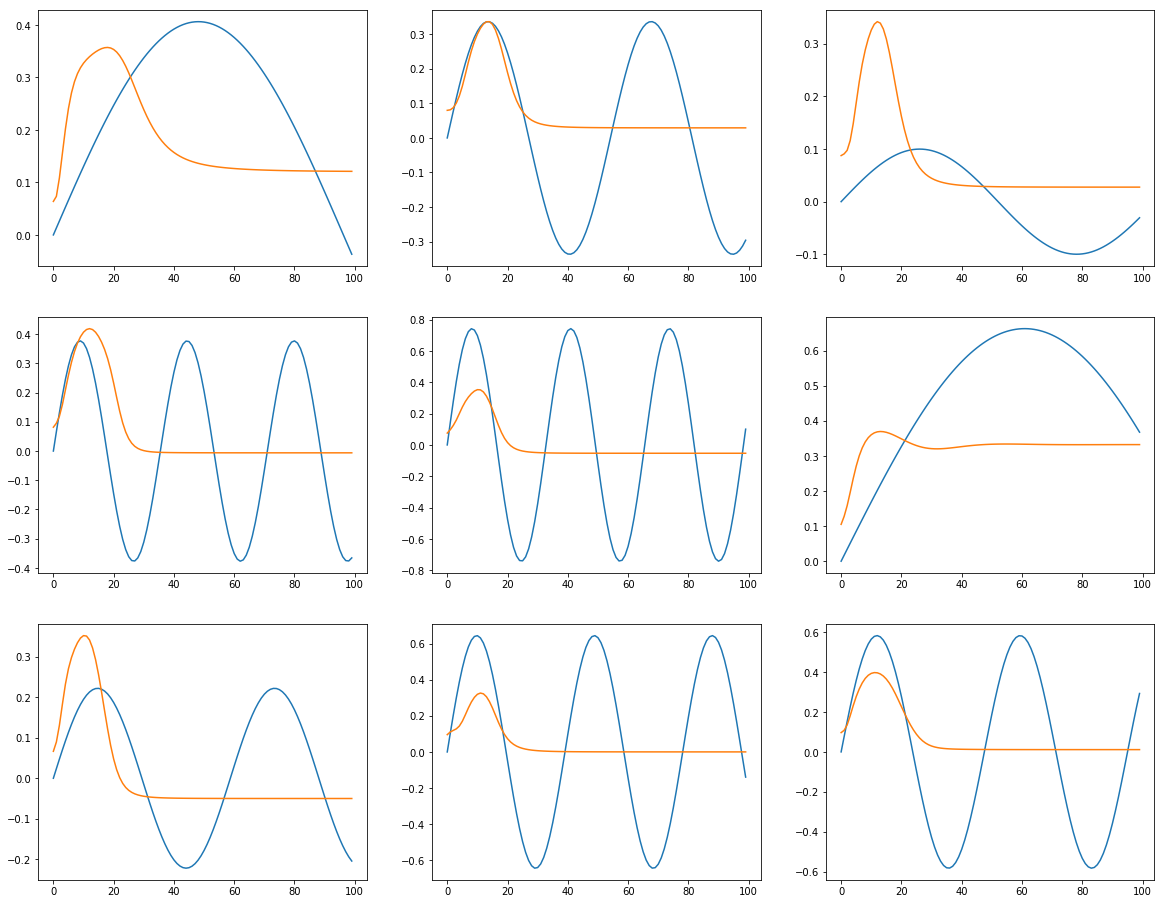

In [94]:
learn.model.eval()
out,_,_ = learn.model(x)
_,axes = plt.subplots(3,3,figsize=(20,16))

for o,r,ax in zip(x,out,axes.flatten()):
    ax.plot(o.flatten())
    ax.plot(r)